# Tamedia - Semi_supervised classification

Xuekai Li

2025_april


### 📦 Environment Setup and Library Imports

This notebook sets up a complete environment for working with a new dataset using both supervised and semi-supervised learning techniques.

#### Included Libraries:
- **NumPy / Pandas** for data handling
- **Matplotlib / Seaborn** for visualization
- **Scikit-learn** for clustering, classification, preprocessing, and evaluation
- **UMAP** for dimensionality reduction and visualization
- **Imbalanced-learn (SMOTE)** to oversample minority classes
- **PyTorch** for implementing reinforcement learning models
- **TQDM** for progress tracking

Also included:
- Suppression of unnecessary warnings
- Expanded DataFrame output settings
- Working directory (`cwd`) retrieval

This cell ensures all tools are loaded and configured before any dataset is loaded or processed.


In [1]:
# === Standard libraries ===
import os
import re
import time
import warnings
from collections import Counter, defaultdict, deque
from time import time

# === Data handling and plotting ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# === Machine learning / preprocessing ===
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import f1_score

# === Deep learning (PyTorch) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# === Imbalanced data ===
from imblearn.over_sampling import SMOTE

# === Dimensionality reduction & plotting ===
import umap
import umap.plot

# === Progress bars ===
from tqdm.notebook import tqdm

# === Working directory ===
cwd = os.getcwd()


### 📥 Load Dataset

The labeled transcript dataset is loaded from an Excel file:

- **Source**: `tamedia 1000 transcripts to label 2024-06-08.xlsx`
- **Index column**: The first column is used as the DataFrame index
- **Preview**: The first few rows are displayed using `.head()`

This dataset likely contains raw textual data alongside labels that will be used for classification or clustering tasks.


In [2]:
# Read the data
df = pd.read_excel(
    os.path.join(cwd, "tamedia 1000 transcripts to label 2024-06-08.xlsx"),
    index_col=0
)
df.head()

,motive_final,textAno4
ID,,
1,"Ratsuche (0.5), Vertrauen (0.5)","SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung (1),SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen (1),"SPEAKER_A : Schweizer Familie , Aboservice , {..."
5,"Vertrauen (0.5), Abgabe (0.5)","SPEAKER_A : Guten Tag , hier ist {name} von de..."


### 🧹 Motive Label Cleaning and Expansion

The dataset contains a `motive_final` column with labels sometimes formatted as multiple entries with embedded probabilities (e.g., `"Selbermachen (0.5), Ratsuche (0.5)"`). This preprocessing routine expands, normalizes, and flattens these entries for further analysis.

#### Key Steps:
1. **Pattern-based Expansion**:
   - Uses regex to strip out probabilities and extract raw motive names.
   - Expands rows containing multiple labels into multiple single-label rows.

2. **Normalization**:
   - Replaces inconsistent labels (e.g., `"Keine "` → `"Keine"`, `"Preisoptimierer"` → `"Preisoptimierung"`).
   - Fills missing or `NaN` labels with `"0"`.

3. **Custom Case Handling**:
   - Manually handles specific free-text mixed label cases like:
     - `"Selbermachen 0.5, Ratsuche 0.5"`
     - `"0.5 Selbermachen, 0.5 Keine"`

#### Output:
- A clean `DataFrame` with one motive per row.
- Shape and unique motive categories printed for inspection.

This preprocessing ensures consistent labeling, which is essential for downstream classification or clustering tasks.


In [3]:
# Define a function to split, expand motive types, and remove probabilities
def split_and_expand_motive_types(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == 'Keine' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    matches = re.findall(r'(\w+)\s*\(\d*\.?\d*\)', text)  # Extract just the motive name, ignoring the probability
    if matches:
        # Generate a new row for each motive type without the probability
        expanded_rows = []
        for match in matches:
            new_row = row.copy()
            new_row['motive_final'] = match  # Set the motive name without the probability
            expanded_rows.append(new_row)
        return expanded_rows
    else:
        return [row]  # Return the original row if no matches found

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types(row)])


######
'''
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0.5 Selbermachen, 0.5 Keine' 'Keine '
 'Abgabe  ' 'Preisoptimierer' 'Selbermachen 0.5, Ratsuche 0.5' nan]
(1079, 2)

'''
df = expanded_df
df['motive_final'] = df['motive_final'].fillna('0')
df['motive_final'] = df['motive_final'].replace('Keine ', 'Keine')
df['motive_final'] = df['motive_final'].replace('Abgabe  ', 'Abgabe')
df['motive_final'] = df['motive_final'].replace('Preisoptimierer', 'Preisoptimierung')


'''
array(['Ratsuche', 'Vertrauen', 'Keine', 'Preisoptimierung', 'Abgabe',
       'Pragmatismus', 'Selbermachen', 'Vermeidung',
       '0.5 Selbermachen, 0.5 Keine', 'Selbermachen 0.5, Ratsuche 0.5',
       '0'], dtype=object)

'''
# Define a function to split, expand motive types, and handle specific cases
def split_and_expand_motive_types2(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == '0' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    expanded_rows = []

    # Handle the specific case "Selbermachen 0.5, Ratsuche 0.5"
    if text == 'Selbermachen 0.5, Ratsuche 0.5':
        motives = ['Selbermachen', 'Ratsuche']
    # Handle the specific case "0.5 Selbermachen, 0.5 n/a"
    elif text == '0.5 Selbermachen, 0.5 Keine':
        motives = ['Selbermachen', 'Keine']
    else:
        # Generic handling: Extract motive names without probabilities
        motives = re.findall(r'(\w+)\s*\d*\.?\d*', text)

    # Generate a new row for each motive name without the probability
    for motive in motives:
        new_row = row.copy()
        new_row['motive_final'] = motive  # Set the motive name without the probability
        expanded_rows.append(new_row)

    return expanded_rows

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types2(row)])
print(expanded_df.motive_final.unique())
print(expanded_df.shape)
expanded_df.head()

''' 
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)

'''
df = expanded_df


['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)


### 🔤 Text Cleaning and Placeholder Translation

This step cleans and standardizes the conversation transcripts to make them suitable for analysis or modeling.

#### Operations:
- **Line Breaks**: Replace all `\n` characters with spaces for consistent formatting.
- **Placeholder Extraction**:
  - Identifies and replaces structured tags such as `{ e-mail }`, `{ town }`, etc.
  - Translates them to German equivalents (e.g., `E-Mail`, `Strassenname`).
- **Speaker Tag Translation**:
  - English speaker labels (`SPEAKER_A`, etc.) are replaced with German versions (`SPRECHER_A`, etc.).
- **Column Renaming**:
  - `textAno4` → `text`
  - `motive_final` → `label`
- **Duplicate Removal**:
  - Ensures unique examples by removing duplicate texts.

#### Output:
A clean and translated DataFrame (`df`) ready for further processing such as tokenization, feature extraction, or model training.


In [4]:
# Replace newlines in text column
df['textAno4'] = df['textAno4'].str.replace('\n', ' ')

# Extract unique patterns
placeholder_pattern = r'\{([^}]+)\}'
speaker_pattern = r'([A-Z_]+)\s*:'

unique_placeholders = set(re.findall(placeholder_pattern, ' '.join(df['textAno4'])))
unique_speakers = set(re.findall(speaker_pattern, ' '.join(df['textAno4'])))

# Create translation mappings
translations = {
    # Placeholders
    ' street { street name ': 'Strassenname',
    ' street name ': 'Strassenname',
    ' number ': 'Nummer',
    ' address ': 'Adresse',
    ' { e-mail ': 'E-Mail',
    ' e-mail ': 'E-Mail',
    'name': 'Name',
    ' town ': 'Stadt',
    
    # Speakers
    'SPEAKER_A': 'SPRECHER_A',
    'SPEAKER_B': 'SPRECHER_B',
    'SPEAKER_C': 'SPRECHER_C',
    'SPEAKER_D': 'SPRECHER_D',
    'SPEAKER_UNKNOWN': 'SPRECHER_UNBEKANNT'
}

# Apply replacements in single pass
for pattern, replacement in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(pattern, replacement)

# Clean and rename columns
print(df.motive_final.unique())

df = (
    df
    .rename(columns={'textAno4': 'text', 'motive_final': 'label'})
    .drop_duplicates(subset='text', keep='first')
)

print(df.head())
print(df.shape)

['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
              label                                               text
1          Ratsuche  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
2             Keine  SPRECHER_B : Berner Zeitung , Aboservice , {Na...
3  Preisoptimierung  SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4         Vertrauen  SPRECHER_A : Schweizer Familie , Aboservice , ...
5         Vertrauen  SPRECHER_A : Guten Tag , hier ist {Name} von d...
(999, 2)


### 📊 Motive Type Distribution

This plot visualizes the frequency of each **motive label** in the dataset using a count plot:

- **X-axis**: Categories of labeled motives
- **Y-axis**: Number of samples per label
- **Color**: Differentiated with a `viridis` palette for clarity

#### Additional:
- The `Counter(df['label'])` output shows exact numeric counts for each category.
- This helps assess **class imbalance**, which is critical for model selection and potential use of techniques like oversampling or class weighting.


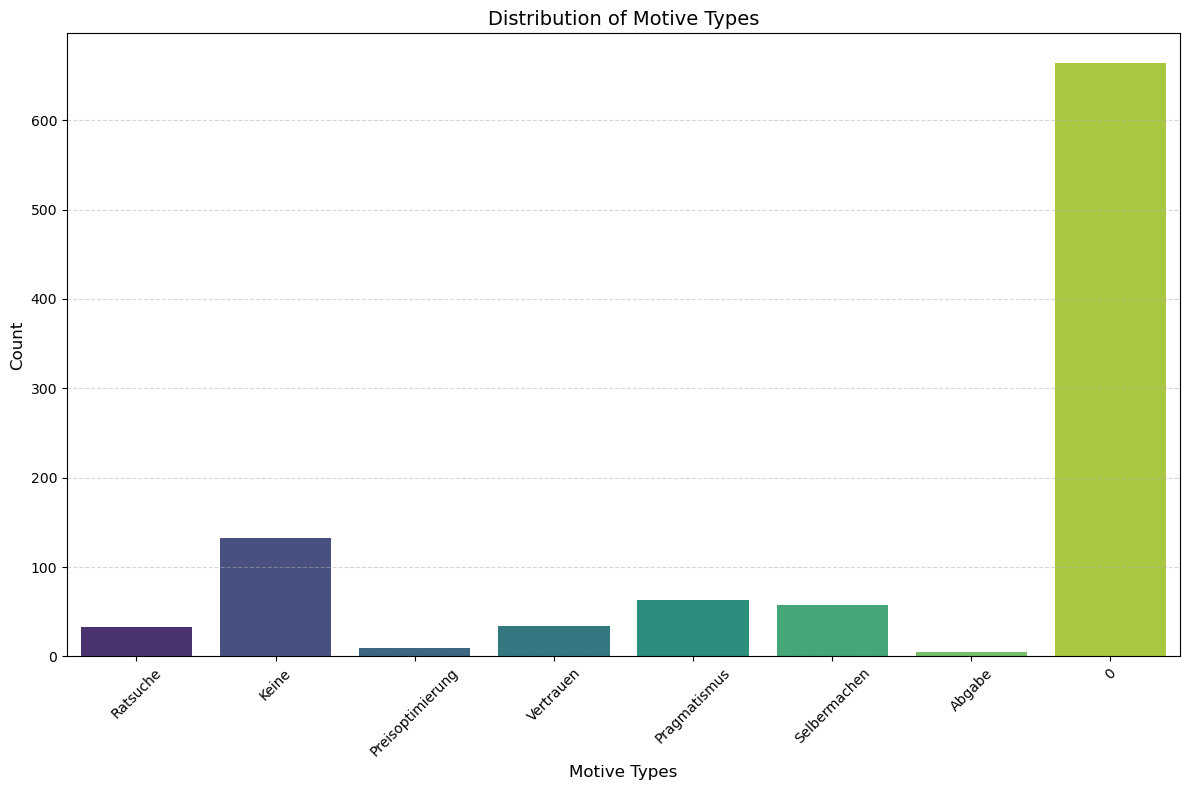

Counter({'0': 664,
         'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33,
         'Preisoptimierung': 9,
         'Abgabe': 5})

In [5]:
# Visualize the distribution of motive types (labels)
plt.figure(figsize=(12, 8))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Distribution of Motive Types", fontsize=14)
plt.xlabel("Motive Types", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# Show exact counts per label
Counter(df['label'])



### 🔢 Token Count Range (Text Length)

This cell performs a basic analysis of text length using **NLTK tokenization**:

- Downloads and uses `punkt` tokenizer to split text into words
- Applies `word_tokenize()` to each text sample in the `text` column
- Reports:
  - **Minimum number of tokens**
  - **Maximum number of tokens**

This provides insight into the **length variability** across examples, which is useful for:
- Model input sizing (e.g., max sequence length)
- Filtering or truncating long/short samples


In [6]:
# Download tokenizer from NLTK
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# Define function to count tokens in a text
def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Calculate min and max token counts in the dataset
min_tokens = df['text'].apply(count_tokens).min()
max_tokens = df['text'].apply(count_tokens).max()

print(f"Minimum token count: {min_tokens}")
print(f"Maximum token count: {max_tokens}")


[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Minimum token count: 39
Maximum token count: 4519


### 📏 Token Count Distribution

This histogram shows the **distribution of text lengths** across the dataset based on word tokens:

- **X-axis**: Number of tokens per text
- **Y-axis**: Frequency of samples with that token count
- **Histogram**: Uses 50 bins for resolution

This analysis helps understand:
- Whether the dataset contains outliers (very short or long texts)
- How to set appropriate input length limits for tokenizers or models


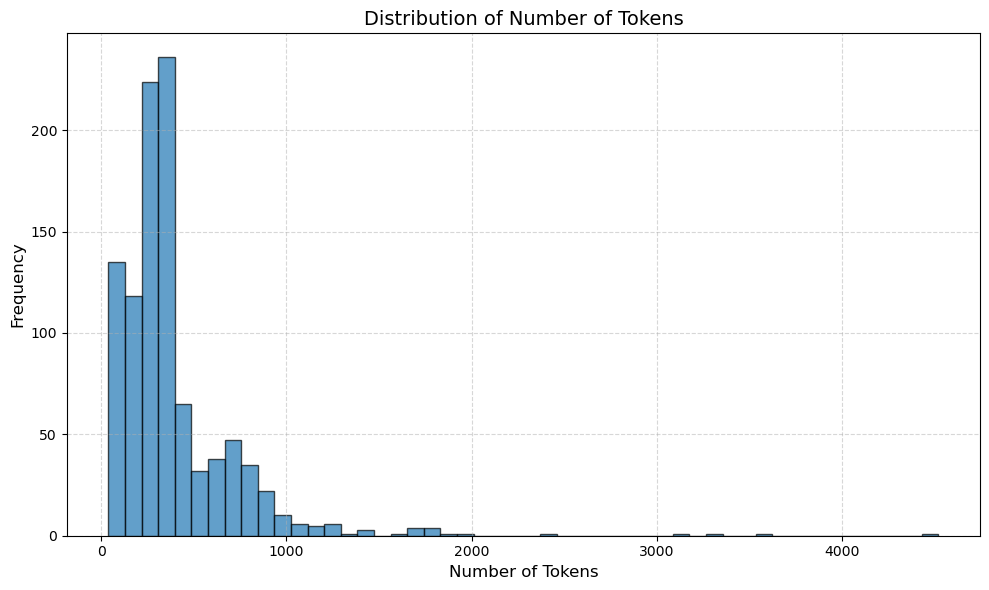

In [7]:
# Plot the distribution of token counts in the dataset
plt.figure(figsize=(10, 6))
plt.hist(
    df['text'].apply(count_tokens),
    bins=50,
    edgecolor='black',
    alpha=0.7
)
plt.title("Distribution of Number of Tokens", fontsize=14)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 🔍 Class Filtering and Dataset Split

To improve model performance and stability, rare motive classes are removed:

- **Excluded labels**: `"Abgabe"` and `"Preisoptimierung"` (too few examples)
- The dataset is split into:
  - `df_l`: **Labeled samples** (labels ≠ `"0"`)
  - `df_ul`: **Unlabeled samples** (labels == `"0"`)

This prepares the data for **semi-supervised learning**, where the model will learn from both labeled and pseudo-labeled examples.


In [8]:
# Remove rare motive classes with insufficient samples for training
df = df[df['label'] != "Abgabe"]
df = df[df['label'] != "Preisoptimierung"]

# Split into labeled and unlabeled subsets
df_l = df[df['label'] != "0"]
df_ul = df[df['label'] == "0"]

# Check label distribution in unlabeled data
from collections import Counter
Counter(df_ul['label'])


Counter({'0': 664})

### 📊 Labeled Data Distribution

This output shows the **class distribution** in the labeled subset (`df_l`) after filtering rare categories.

- Helps verify that the remaining motive classes are sufficiently represented
- Guides decisions around class balancing (e.g., SMOTE, stratification)

This is a key step to ensure effective and fair supervised learning.


In [9]:
# Display label distribution in the labeled dataset

Counter(df_l.label)

Counter({'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33})

### 🧠 Label Encoding and TF-IDF Vectorization

This step converts categorical labels and raw text into machine-readable formats.

#### 1. Label Encoding
- Transforms motive labels into integer-encoded format using `LabelEncoder`
- Required for classification algorithms

#### 2. Text Preparation
- Labeled (`X_l`) and unlabeled (`X_ul`) texts are converted into plain lists

#### 3. TF-IDF Vectorization
- A shared `TfidfVectorizer` is **fit on the full corpus** (labeled + unlabeled)
- Ensures that both datasets use the same vocabulary and vector space
- Only tokens appearing in at least 5 documents and less than 50% of all texts are retained

#### Output:
- `X_l_tfidf`: Sparse matrix for labeled texts
- `X_ul_tfidf`: Sparse matrix for unlabeled texts
- Also prints the number of samples and extracted features


In [10]:

# Set seed for reproducibility
np.random.seed(42)

# Encode text labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(df_l['label'])

# Prepare text data
X_l = df_l['text'].tolist()   # Labeled texts
X_ul = df_ul['text'].tolist()  # Unlabeled texts

# TF-IDF vectorizer (shared vocabulary for both sets)
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=None
)

# Fit on all text and transform separately
t0 = time()
X_all = X_l + X_ul
vectorizer.fit(X_all)

X_l_tfidf = vectorizer.transform(X_l)
X_ul_tfidf = vectorizer.transform(X_ul)

print(f"Vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_l_tfidf.shape[0]}, n_features: {X_l_tfidf.shape[1]}")


Vectorization done in 0.184 s
n_samples: 321, n_features: 1783


In [ ]:
# After TF-IDF transformation
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=2,
    stop_words=None
)
X_tfidf = vectorizer.fit_transform(X_all)

# Check the feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Sort by IDF (importance) -- lower IDF = more common
idf_values = vectorizer.idf_

# Create a DataFrame
import pandas as pd
feature_df = pd.DataFrame({
    'term': feature_names,
    'idf': idf_values
})

# Show top 20 most frequent terms
most_common_terms = feature_df.sort_values(by='idf', ascending=True).head(20)
print(most_common_terms)

# Show top 20 rarest terms
rarest_terms = feature_df.sort_values(by='idf', ascending=False).head(20)
print(rarest_terms)


InvalidParameterError: The 'stop_words' parameter of TfidfVectorizer must be a str among {'english'}, an instance of 'list' or None. Got 'German' instead.

### 🌐 UMAP Projection of Labeled Text Data

This cell visualizes the labeled dataset (`X_l_tfidf`) in **2D space** using **UMAP** (Uniform Manifold Approximation and Projection).

#### Key Details:
- **Distance metric**: `hellinger` — suitable for probability-like TF-IDF data
- **Purpose**: Visualize how well-separated the labeled motive classes are
- **Visualization**:
  - Color-coded by label (`y_encoded`)
  - Uses a categorical colormap (`Paired`) for clear separation

This visualization is helpful for:
- Understanding class overlaps
- Diagnosing mislabeling or noisy classes
- Informing feature engineering or dimensionality reduction strategies


In [11]:
# Dimensionality reduction visualization using UMAP
mapper = umap.UMAP(
    metric='hellinger',
    random_state=42,
    n_components=2  # Explicitly state number of components for visualization
).fit(X_l_tfidf)

<Axes: >

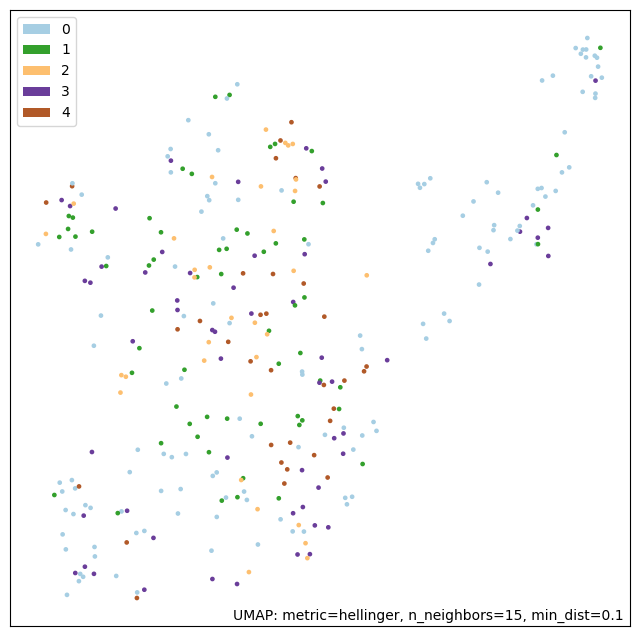

In [12]:
# Visualize using UMAP
umap.plot.points(
    mapper,
    labels=y_encoded,
    width=800,
    height=800,
    color_key_cmap='Paired'
)


### 🔻 UMAP Dimensionality Reduction and Scaling

This step reduces the TF-IDF vectors into a lower-dimensional space using **UMAP** and prepares the data for modeling.

#### Steps:
1. **UMAP Reduction**:
   - Fit on the labeled TF-IDF matrix (`X_l_tfidf`)
   - Transformed to 5 dimensions for compact representation
   - Applied the same transformation to unlabeled data to ensure feature alignment

2. **Standardization**:
   - Both labeled and unlabeled UMAP outputs are scaled using `StandardScaler`
   - Ensures features are centered and variance-normalized for downstream models (especially SVM, KNN)

This prepares the feature vectors for training in a lower-dimensional, dense space — ideal for semi-supervised learning workflows.


In [13]:


# Define UMAP reducer
umap_model = umap.UMAP(
    n_components=5,
    random_state=42
)

t0 = time()

# Fit UMAP on labeled data and transform both labeled and unlabeled sets
X_l_umap = umap_model.fit_transform(X_l_tfidf)
X_ul_umap = umap_model.transform(X_ul_tfidf)

# Scale the reduced feature space
scaler = StandardScaler()
X_l_umap = scaler.fit_transform(X_l_umap)
X_ul_umap = scaler.transform(X_ul_umap)

print(f"UMAP done in {time() - t0:.3f} s")


UMAP done in 2.814 s


### 🧭 UMAP Projection (2D View of Labeled Data)

This scatter plot visualizes the labeled dataset in **UMAP-reduced 2D space**, using dimensions 3 and 4 from the 5D embedding:

- **Color**: Encodes class membership using `y_encoded`
- **X/Y Axes**: Two selected UMAP dimensions to visualize cluster separation
- **Marker size**: Small (`s=3`) for better density display

This view helps verify whether UMAP preserves class structure in the embedding space, which is important for downstream clustering or classification.


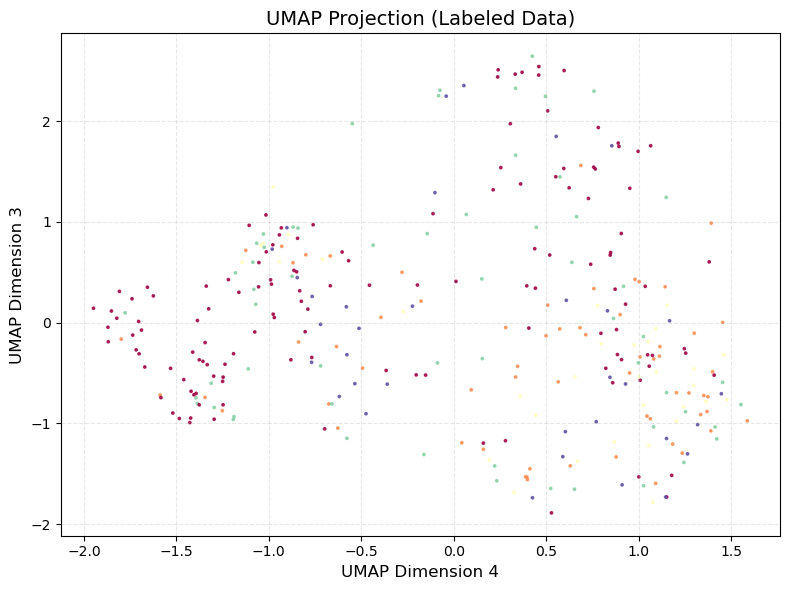

In [14]:
# Visualize labeled data in UMAP-reduced space (2D projection)
plt.figure(figsize=(8, 6))
plt.scatter(
    X_l_umap[:, 3], X_l_umap[:, 2],
    c=y_encoded,
    cmap='Spectral',
    s=3,
    alpha=0.8
)
plt.xlabel("UMAP Dimension 4", fontsize=12)
plt.ylabel("UMAP Dimension 3", fontsize=12)
plt.title("UMAP Projection (Labeled Data)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 🧪 Dataset Splitting and Oversampling

To prepare for supervised training, the labeled dataset is split and balanced as follows:

#### 1. Train/Test/Validation Split
- **Train/Test**: 60% train, 40% test (`stratify` ensures class balance)
- **Train/Validation**: 50/50 split from the training portion
- This results in:
  - `X_train`, `y_train`: Base training set
  - `X_validation`, `y_validation`: Used for model tuning
  - `X_test`, `y_test`: Held-out final evaluation set

#### 2. Class Distribution Visualization
- Three count plots show how balanced each subset is before oversampling

#### 3. SMOTE Oversampling
- **SMOTE** is applied to the training set to synthetically balance underrepresented classes
- A final count plot confirms uniform class distribution

These steps ensure fair evaluation and better generalization, especially in imbalanced classification tasks.


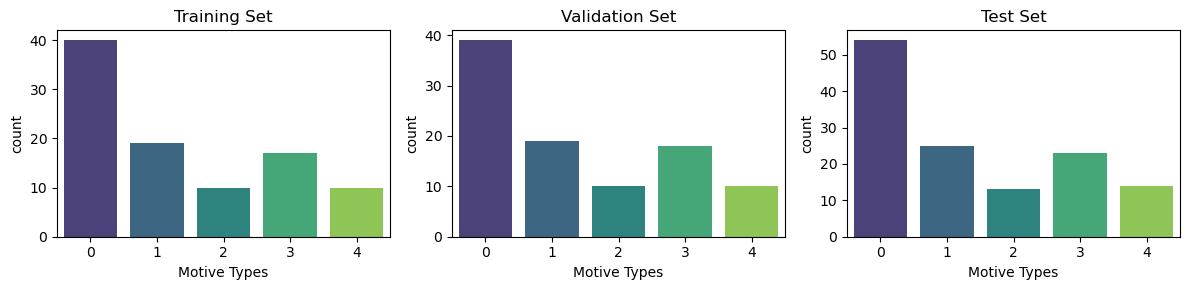

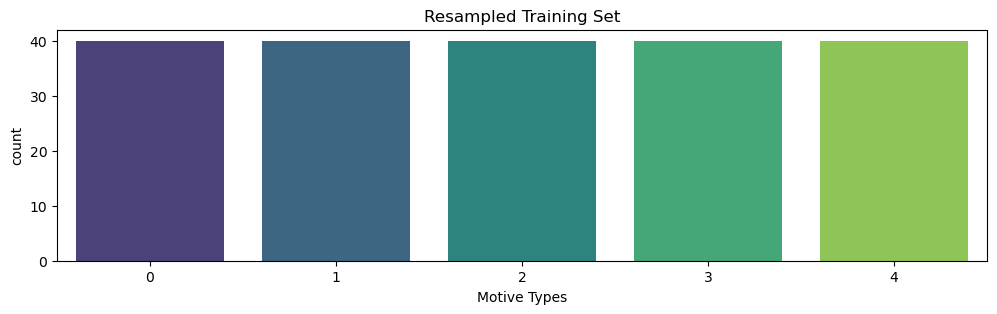

In [15]:


# Split the label data to train and test dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X_l_umap, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)


# Split the training set into training and validation sets
X_validation, X_train, y_validation, y_train = train_test_split(X_train_full, y_train_full, test_size=0.5, stratify=y_train_full, random_state=42)

# plot the distribution of the train, validation and test dataset
plt.figure(figsize=(12, 3))
plt.subplot(131)
sns.countplot(x=y_train, palette='viridis')
plt.title('Training Set')
plt.xlabel('Motive Types')

plt.subplot(132)
sns.countplot(x=y_validation, palette='viridis')
plt.title('Validation Set')
plt.xlabel('Motive Types')


plt.subplot(133)
sns.countplot(x=y_test, palette='viridis')
plt.title('Test Set')
plt.xlabel('Motive Types')
plt.tight_layout()
plt.show()


# Oversample the training set using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Plot the distribution of the resampled training set
plt.figure(figsize=(12, 3))
sns.countplot(x=y_train_resampled, palette='viridis')           
plt.title('Resampled Training Set')
plt.xlabel('Motive Types')
plt.show()
    


### 🤖 Classifier Initialization: KNN and SVM

Two supervised learning models are initialized as baseline classifiers:

#### 1. **K-Nearest Neighbors (KNN)**
- Uses cosine distance to measure similarity between vectors
- Configured with `k=10` neighbors

#### 2. **Support Vector Machine (SVM)**
- RBF (Radial Basis Function) kernel for non-linear classification
- Outputs probabilities (`probability=True`) for use in ensemble and co-training
- High iteration limit for convergence on large or complex datasets

Both models will be trained on the


In [16]:
# Initialize KNN and SVM classifiers
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    metric='cosine'
)

clf_svm = SVC(
    kernel='rbf',
    probability=True,
    tol=1e-4,
    max_iter=10000,
    C=1.0
)

# Store both classifiers in a list for co-training
classifiers = [clf_knn, clf_svm]

### 🔁 Baseline Training and Co-Training Evaluation

This cell trains **KNN** and **SVM** classifiers on SMOTE-balanced labeled data and evaluates their performance **before and after co-training** with pseudo-labeled data.

#### 🔹 Steps:

1. **Train on Labeled Data**:
   - Train KNN and SVM on the original resampled training set
   - Evaluate Macro and Micro F1 on the held-out test set

2. **Confidence-Based Pseudo-Labeling**:
   - Predict probabilities on the unlabeled set (`X_ul_umap`)
   - Select high-confidence samples based on dynamic threshold from validation performance

3. **Cross-Labeling**:
   - Each classifier receives pseudo-labeled samples from the other model
   - They are retrained with the augmented dataset

4. **Evaluation After Co-Training**:
   - Each classifier is re-evaluated on the test set
   - Their outputs are combined using **weighted ensemble voting**
   - Final macro/micro F1 scores are printed

This is the core of a **semi-supervised co-training setup**, where two models mutually reinforce each other using unlabeled data.


In [17]:
# run balseline model  KNN and SVM and print the f1 score for each model
# Initialize classifiers (KNN and SVM) with the labeled training set.
clf_knn.fit(X_train_resampled, y_train_resampled)
clf_svm.fit(X_train_resampled, y_train_resampled) 


# Compute F1-score for validation set
f1_knn = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn = f1_score(y_test, clf_knn.predict(X_test), average='micro')
f1_micro_svm = f1_score(y_test, clf_svm.predict(X_test), average='micro')


##########################
# Co-training settings
X_cotrain = X_ul_umap.copy()
# n_iterations = 10


# Set a threshold for confidence
confidence_threshold = (f1_score(y_validation, clf_knn.predict(X_validation), average='macro') + \
f1_score(y_validation, clf_svm.predict(X_validation), average='macro'))/2.


# Get probability estimates
proba_knn = clf_knn.predict_proba(X_cotrain)
confidence_knn = np.max(proba_knn, axis=1)
labels_knn = np.argmax(proba_knn, axis=1)


proba_svm = clf_svm.predict_proba(X_cotrain)
confidence_svm = np.max(proba_svm, axis=1)
labels_svm = np.argmax(proba_svm, axis=1)

high_conf_knn = confidence_knn > np.percentile(confidence_knn, confidence_threshold * 100.)  # 90th percentile = top 10%
high_conf_svm = confidence_svm > np.percentile(confidence_svm, confidence_threshold * 100.)

# Get indices of high-confidence samples
knn_indices = np.where(high_conf_knn)[0]
svm_indices = np.where(high_conf_svm)[0]
print(len(knn_indices), len(svm_indices))

# Get pseudo-labeled samples
X_knn_add, y_knn_add = X_cotrain[svm_indices], labels_svm[svm_indices]
X_svm_add, y_svm_add = X_cotrain[knn_indices], labels_knn[knn_indices]

# Add high-confidence samples to each classifier’s training set
X_labeled_svm = np.vstack([X_train_resampled, X_svm_add])
y_labeled_svm = np.hstack([y_train_resampled, y_svm_add])

X_labeled_knn = np.vstack([X_train_resampled, X_knn_add])
y_labeled_knn = np.hstack([y_train_resampled, y_knn_add])

# Retrain classifiers
clf_knn.fit(X_labeled_knn, y_labeled_knn)
clf_svm.fit(X_labeled_svm, y_labeled_svm)

# Compute F1-score based classifier weights
classifier_weights = np.array([
    f1_score(y_validation, clf.predict(X_validation), average='weighted')
    for clf in [clf_knn, clf_svm]
])
classifier_weights += 1e-6  # Prevent zero division
classifier_weights /= classifier_weights.sum()  # Normalize weights
print(classifier_weights)

# Compute weighted probability predictions
combined_probabilities = np.average(
    [clf.predict_proba(X_test) for clf in [clf_knn, clf_svm]],
    axis=0,
    weights=classifier_weights
)

# Get final predictions
combined_predictions = np.argmax(combined_probabilities, axis=1)


# Compute final F1 scores
co_f1_macro = f1_score(y_test, combined_predictions, average='macro')
co_f1_micro = f1_score(y_test, combined_predictions, average='micro')


# get f1 scores for each classfier after co-training
f1_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='micro')   
f1_micro_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='micro')
# Print F1 scores for each classifier before and after co-training
print(f"before_co_KNN F1 Macro: {f1_knn}")
print(f"after_co_KNN F1 Macro: {f1_knn_co}")
print("*"*40)
print(f"before_co_SVM F1 Macro: {f1_svm}")
print(f"after_co_SVM F1 Macro: {f1_svm_co}")
print("*"*40)
print(f"before_co_KNN F1 Micro: {f1_micro_knn}")
print(f"after_co_KNN F1 Micro: {f1_micro_knn_co}")
print("*"*40)
print(f"before_co_SVM F1 Micro: {f1_micro_svm}")
print(f"after_co_SVM F1 Micro: {f1_micro_svm_co}")


print("*"*40)

# Print final scores



print(f"Co-training F1 Macro: {co_f1_macro}")
print(f"Co-training F1 Micro: {co_f1_micro}")
# print(f"Co-training F1 Weighted: {co_f1_weighted}")

334 456
[0.49646952 0.50353048]
before_co_KNN F1 Macro: 0.3531622270753421
after_co_KNN F1 Macro: 0.3198643602527097
****************************************
before_co_SVM F1 Macro: 0.3179941354756021
after_co_SVM F1 Macro: 0.34341650901552423
****************************************
before_co_KNN F1 Micro: 0.3953488372093023
after_co_KNN F1 Micro: 0.40310077519379844
****************************************
before_co_SVM F1 Micro: 0.37209302325581395
after_co_SVM F1 Micro: 0.3875968992248062
****************************************
Co-training F1 Macro: 0.3555084458906649
Co-training F1 Micro: 0.4186046511627907


### 🔁 Custom Reinforcement Learning Environment for Co-Training (`Env` Class)

This custom class defines the **environment** for an RL agent that learns to select clusters of unlabeled data to co-train dual classifiers (KNN & SVM).

#### 🔹 Core Components:
- **State Space**: 
  - Based on classifier predictions (`predict_proba`) on cluster centroids
  - Combines both classifiers into one flat feature vector
- **Actions**: 
  - Select from `k` clusters (via Agglomerative Clustering)
- **Reward**:
  - Based on improvement in **Macro-F1 score** on validation/test set
  - Smoothed via a rolling reward baseline

#### 🔹 Key Methods:
- `get_state()`: Returns the current state (classifier outputs on centroids)
- `get_f1()`: Computes ensemble F1 scores via weighted classifier output
- `step(action)`: Performs co-training using the selected cluster and computes new reward/state
- `co_training()`: Executes co-training using mutual pseudo-labeling
- `train_2_clf()`: Resets both classifiers to a baseline state

This environment enables **deep RL agents** (e.g., Actor-Critic) to learn policies that intelligently expand the labeled dataset via confident pseudo-labeling.


In [18]:

class Env:
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset, window_size=10):
        """
        Initialize the environment.
        classifiers: list of classifiers [KNN, SVM]
        input_ul_data: unlabeled feature vectors
        k: number of clusters for actions
        X_test, y_test: evaluation set for computing reward
        X_reset, y_reset: reset baseline training set
        window_size: for smoothing reward signal
        """
        self.models = classifiers
        self.X_ul = input_ul_data
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        self.action_size = k
        self.window_size = window_size

        # --- Clustering unlabeled data into k groups ---
        self.agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
        self.cluster_label = self.agglo.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)

        # --- Compute centroids of each cluster ---
        self.centroids = np.array([
            self.X_ul[self.cluster_label == i].mean(axis=0) for i in self.u_cluster_label
        ])

        # --- Initial state size (2 classifiers * class probabilities per cluster) ---
        self.observation_size = self.get_state(reset=True).shape[1]

        # --- Initialize reward tracking ---
        self.prev_macro_f1 = 0.0
        self.f1_diff_history = deque(maxlen=self.window_size)

    def train_2_clf(self, X, y):
        """Train both classifiers on the same dataset."""
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self, reset=False):
        """Return current state as classifier predictions on centroids."""
        if reset:
            if self.X_reset is None or self.y_reset is None:
                raise ValueError("X_reset and y_reset must be provided.")
            self.train_2_clf(self.X_reset, self.y_reset)

        # --- Get prediction probabilities from both classifiers ---
        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
        except Exception as e:
            raise RuntimeError("Model prediction failed: " + str(e))

        # --- Concatenate and return as single tensor ---
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)

    def get_f1(self, X_eval=None, y_eval=None):
        """Compute weighted ensemble F1 scores."""
        X_eval = X_eval if X_eval is not None else self.X_eval
        y_eval = y_eval if y_eval is not None else self.y_eval

        # --- Compute weights based on individual classifier performance ---
        classifier_weights = np.array([
            f1_score(y_eval, clf.predict(X_eval), average='weighted')
            for clf in self.models
        ])
        classifier_weights += 1e-6
        classifier_weights /= classifier_weights.sum()

        # --- Compute weighted probability outputs ---
        combined_probs = np.average(
            [clf.predict_proba(X_eval) for clf in self.models],
            axis=0,
            weights=classifier_weights
        )

        combined_preds = np.argmax(combined_probs, axis=1)

        # --- Return macro, micro, and weighted F1 scores ---
        return (
            f1_score(y_eval, combined_preds, average='macro'),
            f1_score(y_eval, combined_preds, average='micro'),
            f1_score(y_eval, combined_preds, average='weighted')
        )

    def get_subset(self, action):
        """Return subset of unlabeled data for selected cluster index."""
        return self.X_ul[self.cluster_label == action]

    def co_training(self, subset):
        """Perform co-training using mutually confident pseudo-labels."""
        # --- Compute threshold from current eval performance ---
        confidence_threshold_env = (
            f1_score(self.y_eval, self.models[0].predict(self.X_eval), average='macro') +
            f1_score(self.y_eval, self.models[1].predict(self.X_eval), average='macro')
        ) / 2.

        # --- Get model confidence on the current subset ---
        proba_knn = self.models[0].predict_proba(subset)
        confidence_knn = np.max(proba_knn, axis=1)
        labels_knn = np.argmax(proba_knn, axis=1)

        proba_svm = self.models[1].predict_proba(subset)
        confidence_svm = np.max(proba_svm, axis=1)
        labels_svm = np.argmax(proba_svm, axis=1)

        # --- Select high-confidence pseudo-labeled samples ---
        knn_indices = np.where(confidence_knn > np.percentile(confidence_knn, confidence_threshold_env * 100.))[0]
        svm_indices = np.where(confidence_svm > np.percentile(confidence_svm, confidence_threshold_env * 100.))[0]

        X_knn_add, y_knn_add = subset[svm_indices], labels_svm[svm_indices]
        X_svm_add, y_svm_add = subset[knn_indices], labels_knn[knn_indices]

        # --- Merge with original training set ---
        X_labeled_knn = np.vstack([self.X_reset, X_knn_add])
        y_labeled_knn = np.hstack([self.y_reset, y_knn_add])

        X_labeled_svm = np.vstack([self.X_reset, X_svm_add])
        y_labeled_svm = np.hstack([self.y_reset, y_svm_add])

        # --- Retrain both classifiers ---
        self.models[0].fit(X_labeled_knn, y_labeled_knn)
        self.models[1].fit(X_labeled_svm, y_labeled_svm)

        return self.get_f1()

    def step(self, action):
        """
        Step function for RL agent:
        1. Select cluster using action index
        2. Co-train with subset
        3. Return next state, reward, and updated F1s
        """
        macro_f1_old, _, _ = self.get_f1()
        chosen_subset = self.get_subset(action)
        new_macro_f1, new_micro_f1, new_weighted_f1 = self.co_training(chosen_subset)

        # --- Calculate reward based on smoothed F1 diff ---
        new_state = self.get_state()
        f1_diff = new_macro_f1 - macro_f1_old
        self.f1_diff_history.append(f1_diff)
        baseline = np.mean(self.f1_diff_history) if self.f1_diff_history else f1_diff
        reward = f1_diff - baseline

        return new_state, reward, new_macro_f1, new_micro_f1, new_weighted_f1

### ⚙️ Environment Initialization for Reinforcement Learning Co-Training

This cell initializes the `Env` class which simulates an environment where an RL agent chooses **clusters of unlabeled data** to co-train two classifiers (KNN and SVM).

#### Key Parameters:
- `k = 17`: Number of clusters (action space)
- `X_ul_umap`: Unlabeled UMAP-reduced input features
- `X_train_resampled`: Labeled training set (SMOTE-balanced)
- `X_validation`: Evaluation set (used to compute F1-based reward)

After initialization:
- `env.get_f1()` prints the ensemble performance before any co-training
- `env.get_subset(i)` allows exploration of unlabeled data per cluster/action


In [19]:
# === Initialize RL Co-Training Environment ===

k = 17  # Number of clusters (actions)

env = Env(
    classifiers=classifiers,               # [KNN, SVM]
    input_ul_data=X_ul_umap,               # Unlabeled features (UMAP-reduced)
    k=k,                                   # Number of clusters
    X_test=X_validation,                   # Evaluation data (used for reward computation)
    y_test=y_validation,
    X_reset=X_train_resampled,             # Initial labeled training set
    y_reset=y_train_resampled,
    window_size=10                         # Rolling window size for reward smoothing
)

# === Sanity check: evaluate initial ensemble F1 scores ===
initial_macro, initial_micro, initial_weighted = env.get_f1()
print(f"Initial Macro F1: {initial_macro:.4f}")
print(f"Initial Micro F1: {initial_micro:.4f}")
print(f"Initial Weighted F1: {initial_weighted:.4f}")

# Optional: Inspect a cluster (action)
# subset_2 = env.get_subset(2)


Initial Macro F1: 0.3436
Initial Micro F1: 0.4271
Initial Weighted F1: 0.4352


### 🧠 Actor-Critic Network

This is a neural network implementation of the **Actor-Critic architecture**, where:
- **Actor** selects actions (i.e., which cluster to label next) based on a policy.
- **Critic** evaluates the quality of the selected state using a value function.

#### Network Structure:
- Two shared fully connected layers (128 units each, ReLU activations)
- **Actor Head**: Outputs softmax probabilities over `k` actions (clusters)
- **Critic Head**: Outputs a scalar value representing the expected return from the current state

This model will be trained using policy gradients and value-based updates to learn optimal data selection strategies in a semi-supervised setting.


In [20]:
# === Actor-Critic Network for Policy Optimization ===



class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        """
        Actor-Critic Network:
        - Shared MLP backbone
        - Actor head: outputs a probability distribution over actions
        - Critic head: estimates the value of the current state
        """
        super(ActorCritic, self).__init__()

        # --- Shared layers (Feature extractor) ---
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # --- Actor: predicts action probabilities ---
        self.actor = nn.Linear(128, action_size)

        # --- Critic: estimates scalar state value ---
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        """
        Forward pass:
        - Input: state representation (flattened tensor)
        - Output:
            - action_probs: Softmax probability over discrete actions
            - state_value: Scalar value for current state (critic estimate)
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output policy distribution and state value
        action_probs = F.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)

        return action_probs, state_value


### 🧠 Actor-Critic Agent Initialization

This cell prepares the Actor-Critic reinforcement learning agent and its training loop parameters.

#### Key Elements:
- **Model**: Initialized with `state_size` and `action_size` derived from the `Env` class
- **Optimizer**: Uses Adam for efficient joint updates to actor and critic weights
- **Hyperparameters**:
  - `gamma = 0.99`: High discount factor favors long-term reward
  - `num_episodes = 200`: Number of RL episodes to run
- **Tracking Arrays**:
  - Episode-level and per-timestep rewards and F1 scores are logged for analysis and plotting

This setup enables episodic training with detailed feedback for each policy iteration.


In [21]:


# === Initialize Actor-Critic Model ===

# Instantiate the model using environment state and action dimensions
actor_critic = ActorCritic(
    state_size=env.observation_size,
    action_size=env.action_size
)

# Optimizer for both actor and critic parameters
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# === RL Training Parameters ===
num_episodes = 200       # Total training episodes
gamma = 0.99             # Discount factor for future rewards

# === Score Tracking ===
episode_rewards = []     # Total reward per episode
episode_f1 = []          # All macro F1s across timesteps
macro_f1_scores = []     # Macro F1 per step in final episode
micro_f1_scores = []     # Micro F1 per step in final episode


### 🎮 Actor-Critic Training Loop

This loop performs episodic training using the **Actor-Critic algorithm** on the `Env` environment:

#### 🔁 Per Episode:
- Reset environment state
- Perform 199 time steps:
  - Agent selects an action using its policy network
  - Environment returns next state, reward, and F1 scores
  - Compute **advantage** (TD error) and update:
    - **Actor** using policy gradients
    - **Critic** using value loss
- Track macro F1 per step and cumulative reward per episode

#### 📈 Logging:
- `episode_rewards`: Cumulative reward per episode
- `macro_f1_scores` / `micro_f1_scores`: Performance on final episode
- `episode_f1`: All macro F1s over time

This structure enables policy optimization through interaction with the environment to improve co-training effectiveness.


In [22]:


# === Main Training Loop ===

for episode in tqdm(range(num_episodes)):
    # Reset environment and get initial state
    state = env.get_state(reset=True)
    episode_reward = 0

    # === Time steps per episode ===
    for t in range(1, 200):
        # --- Forward pass through actor-critic network ---
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # --- Take action in environment ---
        next_state, reward, macro_f1, micro_f1, new_weighted_f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # --- Compute TD advantage (reward + future - current) ---
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # --- Actor loss: policy gradient with advantage ---
        actor_loss = -dist.log_prob(action) * advantage.detach()

        # --- Critic loss: mean squared error of value prediction ---
        critic_loss = advantage.pow(2)

        # --- Backpropagation and optimization step ---
        total_loss = actor_loss + critic_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # --- Update state and logging ---
        state = next_state
        episode_reward += reward
        episode_f1.append(macro_f1)

        # Log final episode step-level F1s
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    # === Log episode-level reward ===
    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {episode_reward:.4f}")


  0%|          | 1/200 [00:05<19:25,  5.85s/it]

Episode 0, Total Reward: 0.0212


  6%|▌         | 11/200 [01:05<18:57,  6.02s/it]

Episode 10, Total Reward: -0.0247


 10%|█         | 21/200 [02:07<18:25,  6.18s/it]

Episode 20, Total Reward: 0.0016


 16%|█▌        | 31/200 [03:07<17:08,  6.09s/it]

Episode 30, Total Reward: 0.0017


 20%|██        | 41/200 [04:09<16:22,  6.18s/it]

Episode 40, Total Reward: 0.0130


 26%|██▌       | 51/200 [05:13<15:37,  6.29s/it]

Episode 50, Total Reward: -0.0033


 30%|███       | 61/200 [06:18<15:51,  6.85s/it]

Episode 60, Total Reward: 0.0014


 36%|███▌      | 71/200 [07:31<15:10,  7.06s/it]

Episode 70, Total Reward: -0.0001


 40%|████      | 81/200 [08:40<13:24,  6.76s/it]

Episode 80, Total Reward: 0.0011


 46%|████▌     | 91/200 [09:45<11:55,  6.56s/it]

Episode 90, Total Reward: -0.0130


 50%|█████     | 101/200 [10:55<11:25,  6.92s/it]

Episode 100, Total Reward: 0.0015


 56%|█████▌    | 111/200 [12:03<10:14,  6.91s/it]

Episode 110, Total Reward: -0.0082


 60%|██████    | 121/200 [13:14<09:08,  6.95s/it]

Episode 120, Total Reward: 0.0134


 66%|██████▌   | 131/200 [14:25<08:14,  7.17s/it]

Episode 130, Total Reward: 0.0113


 70%|███████   | 141/200 [15:36<06:59,  7.11s/it]

Episode 140, Total Reward: 0.0026


 76%|███████▌  | 151/200 [16:48<05:50,  7.16s/it]

Episode 150, Total Reward: 0.0001


 80%|████████  | 161/200 [17:59<04:43,  7.27s/it]

Episode 160, Total Reward: 0.0022


 86%|████████▌ | 171/200 [19:12<03:29,  7.23s/it]

Episode 170, Total Reward: 0.0165


 90%|█████████ | 181/200 [20:24<02:18,  7.29s/it]

Episode 180, Total Reward: 0.0039


 96%|█████████▌| 191/200 [21:35<01:03,  7.00s/it]

Episode 190, Total Reward: 0.0188


100%|██████████| 200/200 [22:39<00:00,  6.80s/it]


### ✅ Final Evaluation: RL-Guided Co-Training (coRL)

After training with the Actor-Critic agent, we evaluate the **ensemble model performance** on the held-out test set (`X_test`, `y_test`).

#### Metrics:
- **Macro F1**: Treats all classes equally, good for imbalance
- **Micro F1**: Aggregates contributions of all classes, favors large ones

These scores reflect the effectiveness of the reinforcement learning strategy in selecting high-value unlabeled data clusters for co-training.


In [23]:
# === Final Evaluation of RL Co-Training (coRL) ===

# Evaluate the final ensemble on the test set
corl_f1_macro, corl_f1_micro, _ = env.get_f1(
    X_eval=X_test,
    y_eval=y_test
)

# Print final F1 scores
print(f"RL Co-training Combined F1 Macro: {corl_f1_macro:.4f}")
print(f"RL Co-training Combined F1 Micro: {corl_f1_micro:.4f}")


RL Co-training Combined F1 Macro: 0.3157
RL Co-training Combined F1 Micro: 0.3798


### 📈 Plot 1: RL Episode Reward Curve

This plot shows the **total reward per episode** during training.

#### Interpretation:
- An **increasing trend** implies the agent is learning to select better unlabeled clusters
- Reward is based on **Macro-F1 improvement**, so it reflects actual model gains
- Helps monitor RL training stability and convergence

This is one of the most important diagnostics for reinforcement learning performance.


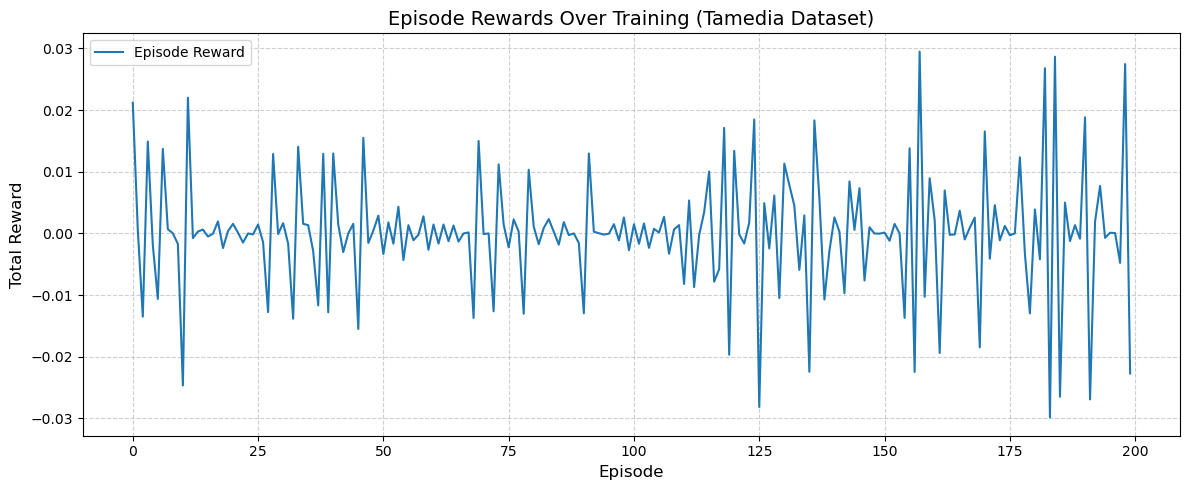

In [24]:
# === Plot 1: Episode-Level Rewards Over Training ===

plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label="Episode Reward")
plt.title("Episode Rewards Over Training (Tamedia Dataset)", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### 📊 Plot 2: Average Macro-F1 per Episode

This plot tracks the **average Macro-F1 score** per episode throughout the training process.

#### Why it's useful:
- Complements the reward curve by showing actual classifier performance
- Smooths out per-timestep noise to reveal **macro-level trends**
- Useful for detecting performance plateaus, surges, or instability

If this line trends upward, your RL agent is guiding the co-training process effectively.


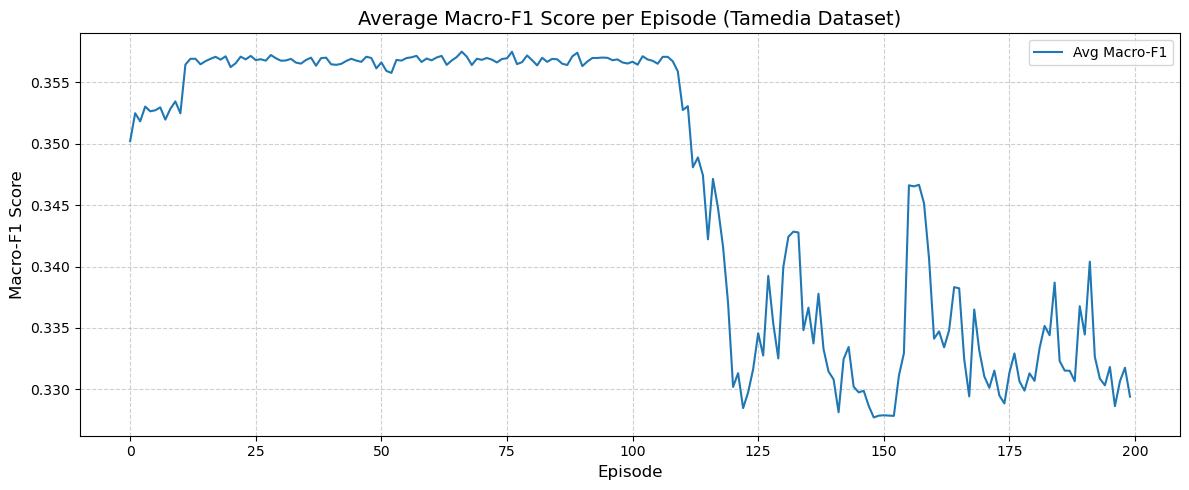

In [25]:
# === Plot 2: Average Macro-F1 Score per Episode ===

# Reconstruct macro-F1 matrix (episodes × steps)
steps_per_episode = 199
f1_matrix = np.array(episode_f1).reshape(-1, steps_per_episode)

# Compute per-episode average Macro-F1
avg_f1_per_episode = f1_matrix.mean(axis=1)

# Plot average Macro-F1 over training
plt.figure(figsize=(12, 5))
plt.plot(avg_f1_per_episode, label="Avg Macro-F1")
plt.title("Average Macro-F1 Score per Episode (Tamedia Dataset)", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Macro-F1 Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### 📉 Plot 3: Final Episode F1 Scores (Macro & Micro)

This plot visualizes the **Macro-F1** and **Micro-F1** scores at each step during the final episode of RL co-training.

#### What it shows:
- **Macro-F1** (blue): Emphasizes balanced performance across all motive classes
- **Micro-F1** (orange): Emphasizes performance on larger or majority classes
- Tracks how each co-training step (action) affected performance

This is useful for diagnosing:
- Performance stability within an episode
- Short-term regressions or improvements
- When the model peaks during the decision sequence


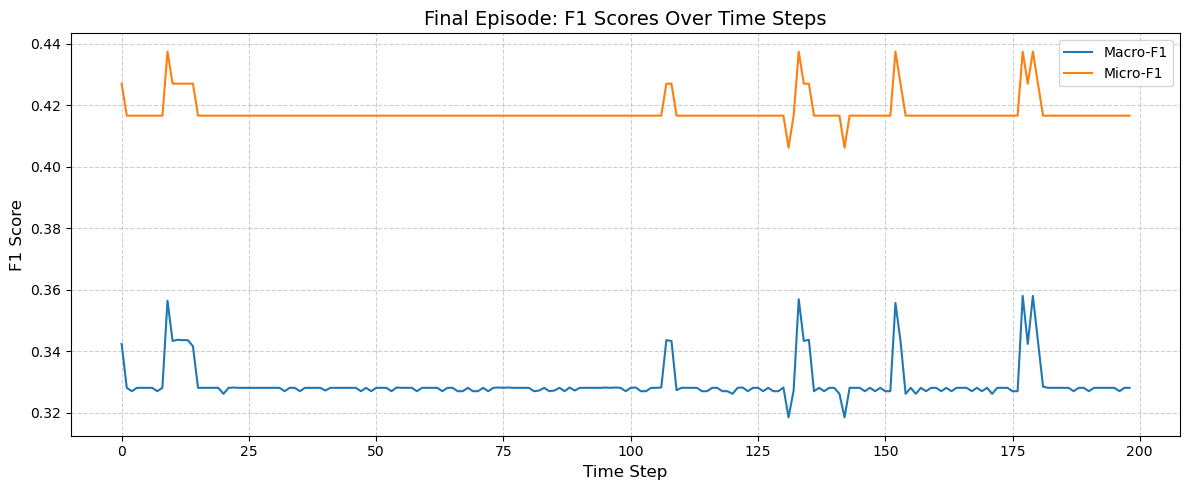

In [26]:
# === Plot 3: Macro vs Micro F1 Scores During Final Episode ===

plt.figure(figsize=(12, 5))
plt.plot(macro_f1_scores, label='Macro-F1')
plt.plot(micro_f1_scores, label='Micro-F1')
plt.title("Final Episode: F1 Scores Over Time Steps", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
